# Introduction

Using the development version of [scikit-learn](http://scikit-learn.org/dev/documentation.html), we construct a neural network (NN) regression model to map from a quantum mechanical potential to the energy levels (eigenvalues) for the single-particle system. The potential $V(x)$ is defined in the range $x\in [-1,1]$ and has the boundary conditions $V(\pm 1) = \infty$. The primary purpose of this notebook is to determine the optimal parameters of the NN. We do this using $10^4$ training examples. We train using these parameters. 

The potentials used for training and testing are generated in [potentials.ipynb](potentials.ipynb). The eigenvalues for all potentials are calculated in [eigenvalues.ipynb](eigenvalues.ipynb).

Documentation for `sklearn`'s supervised NN tools can be found here: http://scikit-learn.org/dev/modules/neural_networks_supervised.html. While already quite good, this documentation still appears to be "under construction".

# Preliminaries

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [2]:
# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E5)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

# Load the pretrained net:
filepathNN = "../Data/NN/NN" + str(int(1E4)) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".pkl"
model = joblib.load(filepathNN);

# We define functios that help us map the Fourier-space potentials into coordinate space.
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))

In [3]:
print("Data shape: ", data.shape, 
      "\nSine coefficients shape: ", VSns.shape,
      "\nCosine coefficients shape: ", VCns.shape, eigs.shape,
      "\nStd. dev. sh`ape: ", dataSD.shape
     )

Data shape:  (100000, 60) 
Sine coefficients shape:  (100000, 10) 
Cosine coefficients shape:  (100000, 10) (100000, 40) 
Std. dev. sh`ape:  (40,)


# Preprocessing

In [4]:
# Number of x coordinates:
Nx = 100
xs = np.linspace(-1,1,Nx)

# The coordinate space potentials:
VSs = VS(ns,xs)
VCs = VC(ns,xs)
Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)
VgridFlipped = np.dot(-VSns,VSs) + np.dot(VCns,VCs)

# Make sure the flip worked by looking at a random potential:
rint = randint(0, NV)
print("First 4 values of Vgrid[" +
      str(rint) + 
      "]:" , Vgrid[rint][0:4])
print("Last 4 values of VgridFlipped[" +
      str(rint) + 
      "]:", VgridFlipped[rint][-4::])

First 4 values of Vgrid[66659]: [-2.48042081 -2.9374298  -3.32585269 -3.59082927]
Last 4 values of VgridFlipped[66659]: [-3.59082927 -3.32585269 -2.9374298  -2.48042081]


In [5]:
numeigs = 10
X = np.concatenate( (Vgrid, VgridFlipped) )
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [6]:
# Split test and train
test_frac = 0.4
random_state = 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (200000, 100) (200000, 10)
X_train shape, y_train shape:  (120000, 100) (120000, 10)
X_test shape, y_test shape:  (80000, 100) (80000, 10)


# Neural network

## Training

In [7]:
model.set_params(regr__hidden_layer_sizes = (50,30), regr__tol = 0.000001, regr__warm_start = False)
model.fit(X_test, y_test);

Iteration 1, loss = 0.04722137
Iteration 2, loss = 0.01949562
Iteration 3, loss = 0.01565071
Iteration 4, loss = 0.01356339
Iteration 5, loss = 0.01207864
Iteration 6, loss = 0.01090287
Iteration 7, loss = 0.00989551
Iteration 8, loss = 0.00904416
Iteration 9, loss = 0.00830559
Iteration 10, loss = 0.00765040
Iteration 11, loss = 0.00706903
Iteration 12, loss = 0.00655598
Iteration 13, loss = 0.00610527
Iteration 14, loss = 0.00569418
Iteration 15, loss = 0.00533895
Iteration 16, loss = 0.00501572
Iteration 17, loss = 0.00474127
Iteration 18, loss = 0.00448928
Iteration 19, loss = 0.00427168
Iteration 20, loss = 0.00407932
Iteration 21, loss = 0.00391016
Iteration 22, loss = 0.00375487
Iteration 23, loss = 0.00362340
Iteration 24, loss = 0.00350967
Iteration 25, loss = 0.00339994
Iteration 26, loss = 0.00331341
Iteration 27, loss = 0.00322969
Iteration 28, loss = 0.00315608
Iteration 29, loss = 0.00309320
Iteration 30, loss = 0.00303729
Iteration 31, loss = 0.00298432
Iteration 32, los

## Testing

We now test the NN on the test set. We measure the error for each eigenvalue relative to the width of the distribution of that eigenvalue over all of the generated potentials. Alternatively (and similarly) one could measure the error relative to the error incurred by simply guessing that the correct value equaled the uniform square-well value.

In [8]:
y_pred = model.predict(X_test)
y_scaled_err = np.sqrt(np.mean((y_pred - y_test)**2/dataSD[0:numeigs]**2, axis = 0))
print("Scaled RMS error by eigenvalue:\n", y_scaled_err)
print("Average of scaled RMS errors:\n ", np.mean(np.abs(y_scaled_err)))

Scaled RMS error by eigenvalue:
 [ 0.0628793   0.0943808   0.10644885  0.11793691  0.15665449  0.19869109
  0.21554513  0.22513697  0.22895893  0.15356781]
Average of scaled RMS errors:
  0.156020028283


# Visualizing the results

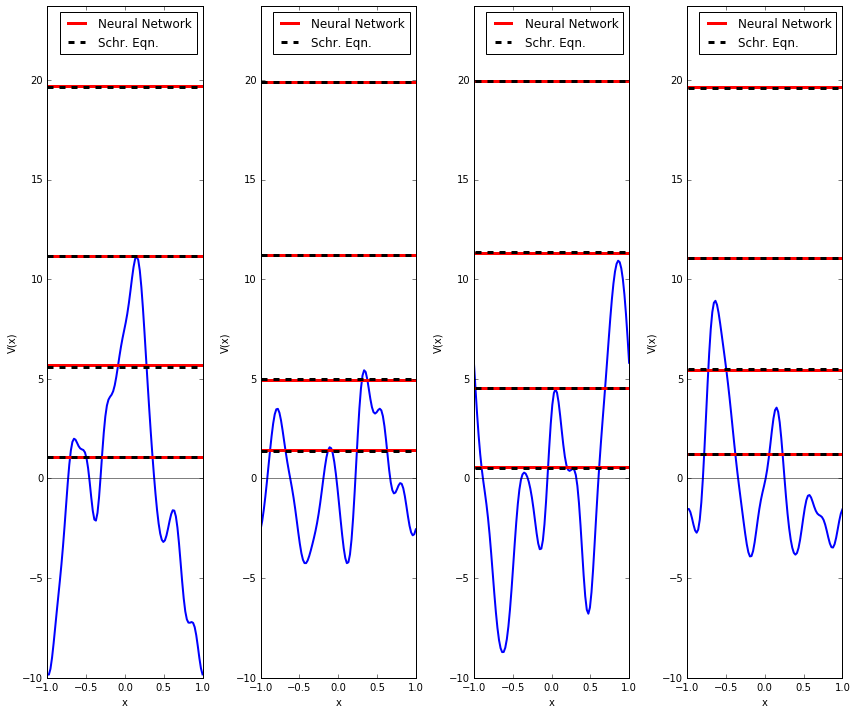

In [9]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 4

def E0(n):
    return n**2 * np.pi**2 / 8.

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,10*nrows)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(xs, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=E0(j+1)+y_pred[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=E0(j+1)+y_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-V20, 1.2*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."])

plt.tight_layout();
plt.show();
plt.draw()
fig.savefig("../Plots/NNPred.png")